In [5]:
ComputeLB = True
DogsOnly = True

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = 'data/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'Images/')
breeds = os.listdir(ROOT + 'Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        #print(breed)
        #print(ROOT+'Annotation/'+breed)
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            #print(dog)
            img_path = ROOT+'all-images/'+dog+'.jpg'
            img = Image.open(img_path) 
            #print(img_path)
            try: img = Image.open(img_path) 
            except: continue
            tree = ET.parse(ROOT+'/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            try:
                for o in objects:
                    bndbox = o.find('bndbox') 
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    w = np.min((xmax - xmin, ymax - ymin))
                    img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                    img2 = img2.resize((64,64), Image.ANTIALIAS)
                    imagesIn[idxIn,:,:,:] = np.asarray(img2)
                    #if idxIn%1000==0: print(idxIn)
                    namesIn.append(breed)
                    idxIn += 1
            except:
                pass
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [7]:


from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
import tensorflow as tf



In [8]:


# BUILD GENERATIVE NETWORK
direct_input = Input((10000,))
x = Dense(2048, activation='elu')(direct_input)
x = Reshape((8,8,32))(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
decoder = Model(direct_input, decoded)
decoder.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
decoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              20482048  
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         36992     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [9]:
# TRAINING DATA
idx = np.random.randint(0,idxIn,10000)
train_y = imagesIn[idx,:,:,:]/255.
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1

In [10]:


# TRAIN NETWORK
lr = 0.005
for k in range(50):
    annealer = LearningRateScheduler(lambda x: lr)
    h = decoder.fit(train_X, train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    if k%5==4: print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.54: lr = 0.001



Epoch 50 /500 - loss = 0.54012013588
Epoch 100 /500 - loss = 0.536410351944
Epoch 150 /500 - loss = 0.535613654518
Epoch 200 /500 - loss = 0.535047480774
Epoch 250 /500 - loss = 0.534695627403
Epoch 300 /500 - loss = 0.534498246574
Epoch 350 /500 - loss = 0.534316007423
Epoch 400 /500 - loss = 0.534142655563
Epoch 450 /500 - loss = 0.534032375622
Epoch 500 /500 - loss = 0.53403041935


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2722566275446367259
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 87097344
locality {
  bus_id: 1
}
incarnation: 4296602722114951644
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0"
]


In [12]:
tf.test.is_gpu_available()

True

Generate Random Dogs


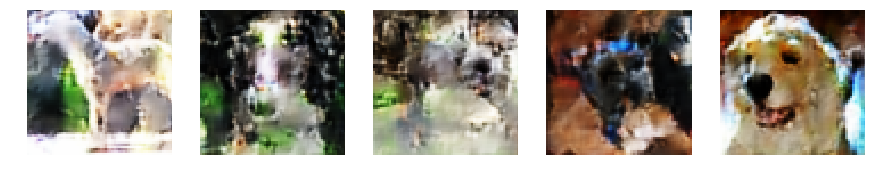

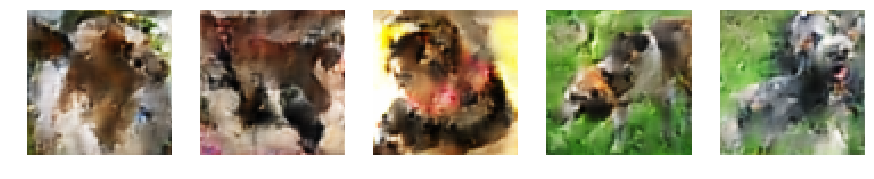

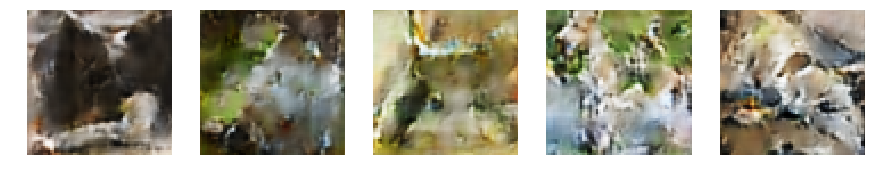

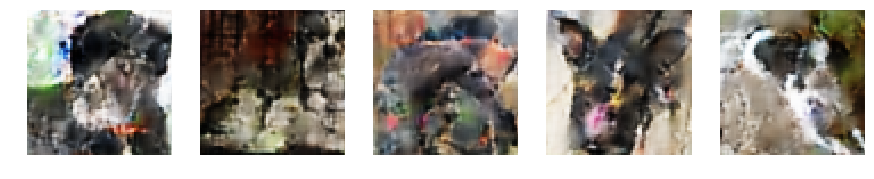

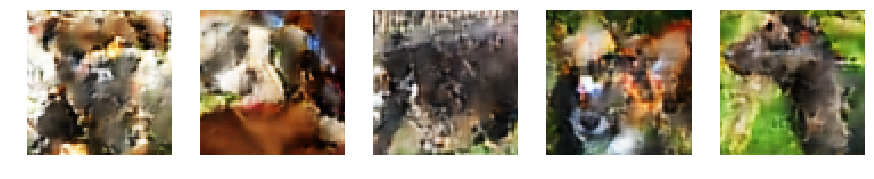

In [14]:


print('Generate Random Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        xx[np.random.randint(10000)] = 0.75
        #xx[np.random.randint(10000)] = 0.25
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()



Walk in Latent Space


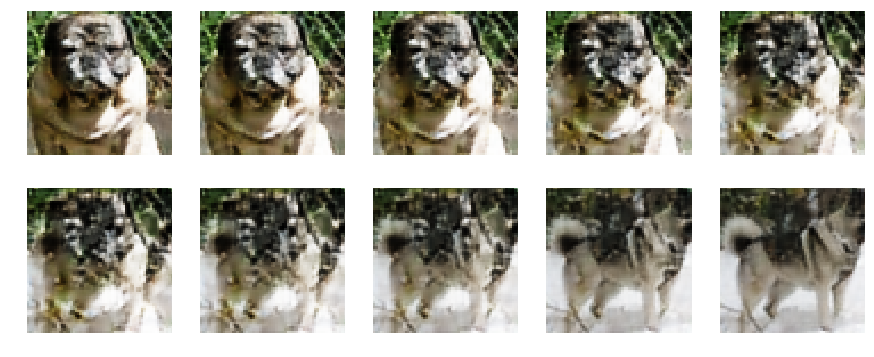

Walk in Latent Space


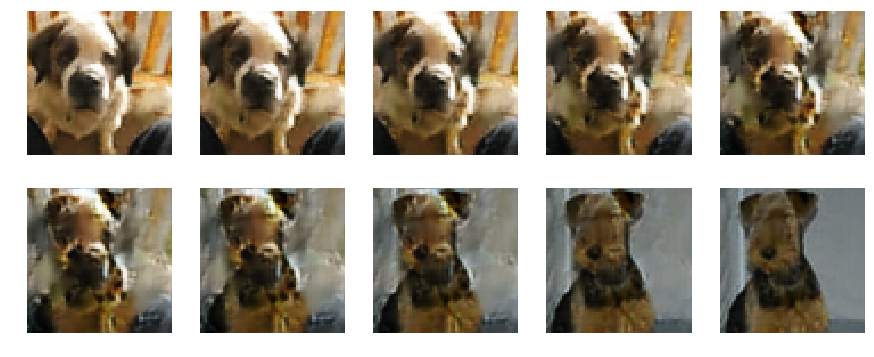

Walk in Latent Space


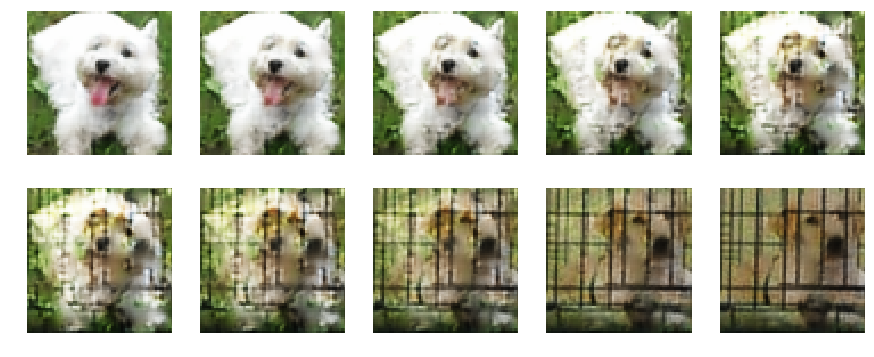

In [15]:


for k in range(3):
    print('Walk in Latent Space') 
    a = np.random.randint(10000)
    b = np.random.randint(10000)
    plt.figure(figsize=(15,6))
    for j in range(10):
        xx = np.zeros((10000))
        theta = j/9
        xx[a] = theta; xx[b] = 1-theta
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(2,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()



In [16]:


# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
for k in range(10000):
    # GENERATE NEW DOGS
    xx = np.zeros((10000))
    xx[np.random.randint(10000)] = 0.99
    xx[np.random.randint(10000)] = 0.01
    img = decoder.predict(xx.reshape((-1,10000)))
    img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
    # SAVE TO ZIP FILE  
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

